# Split dataset
Split in 70/30 Training & Test sets. 

In [1]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 1. Read and Check dataset

In [3]:
df = pd.read_csv("../results/data_def.csv")

print("Shape:")
print(df.shape)
print("------------------------------------------------------")

print("Columns:")
print(df.columns)
print("------------------------------------------------------")

print("Info:")
print(df.info())

Shape:
(294383, 17)
------------------------------------------------------
Columns:
Index(['barcode', 'product_name', 'nutriscore', 'nova_group',
       'mapped_category', 'labels_string', 'n_labels_total',
       'labels_1_intrinsic', 'n_1_intrinsic', 'labels_2_extrinsic',
       'n_2_extrinsic', 'labels_3_packaging', 'n_3_packaging', 'brands',
       'countries', 'n_additives', 'n_ingredients'],
      dtype='object')
------------------------------------------------------
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294383 entries, 0 to 294382
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   barcode             294383 non-null  object 
 1   product_name        291197 non-null  object 
 2   nutriscore          294383 non-null  object 
 3   nova_group          294383 non-null  int64  
 4   mapped_category     294383 non-null  object 
 5   labels_string       294383 non-null  object 
 6   

C:\Users\Voorro\AppData\Local\Temp\ipykernel_1348\1214245525.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../results/data_def.csv")


In [13]:
df.sample(n=25, random_state=42)

,barcode,product_name,nutriscore,nova_group,mapped_category,labels_string,n_labels_total,labels_1_intrinsic,n_1_intrinsic,labels_2_extrinsic,n_2_extrinsic,labels_3_packaging,n_3_packaging,brands,countries,n_additives,n_ingredients,main_mapped_category,label_tier
154295,3217662901652,Nougat de Montelimar,e,4,9.4 Sweets,ORIGIN_COUNTRY_FR,1,NaN,0,ORIGIN_COUNTRY_FR,1,NaN,0,Arnaud Soubeyran,france,0.0,22.0,9. Sweet Products & Desserts,1
287542,10004860049031311100,Pommes séchées,c,1,2.1 Fruits,EU_ORGANIC_CERT_FR|EU_ORGANIC_LOGO|LOW_OR_NO_S...,5,LOW_OR_NO_SALT|NO_ADDED_SALT|NO_ADDED_SUGAR,3,EU_ORGANIC_CERT_FR|EU_ORGANIC_LOGO,2,NaN,0,Juste Bio,france,0.0,1.0,2. Fruits & Vegetables,2
133687,0016000485419,Crunchy,e,4,3.3 Breakfast cereals,NATURAL_100,1,NATURAL_100,1,NaN,0,NaN,0,Nature Valle,mexico,2.0,15.0,3. Cereals & Starches,1
59511,3337739001938,sauce bolognaise végétale,b,3,6.2 Dressings and sauces,EU_ORGANIC_LOGO|EU_ORGANIC_NATIONAL_MARK_FR_AB,2,NaN,0,EU_ORGANIC_LOGO|EU_ORGANIC_NATIONAL_MARK_FR_AB,2,NaN,0,Sol'via,france,0.0,19.0,6. Fats & Sauces,1
14231,830811001855,Organic Extra Virgin Olive Oil,b,2,6.1 Fats & oils,EU_ORGANIC_LOGO|NON_GMO,2,NaN,0,EU_ORGANIC_LOGO|NON_GMO,2,NaN,0,Massimo Gusto,united-states|world,0.0,1.0,6. Fats & Sauces,1
100396,5400101019058,Salade de poulpes,d,3,2.2 Vegetables,ORIGIN_COUNTRY_BE,1,NaN,0,ORIGIN_COUNTRY_BE,1,NaN,0,carrefour,belgium,0.0,12.0,2. Fruits & Vegetables,1
117087,8410014307682,Napolitanas,e,4,9.1 Biscuits and cakes,GREEN_DOT,1,NaN,0,NaN,0,GREEN_DOT,1,Cuétara,spain,3.0,16.0,9. Sweet Products & Desserts,1
219823,0797776401192,Tropical Coconut Ice Cream,d,4,4.4 Ice cream,HACCP|ISO_22000|NO_DAIRY_ADDED|NO_GLUTEN|VEGAN...,6,NO_GLUTEN,1,HACCP|ISO_22000|NO_DAIRY_ADDED|VEGAN|VEGETARIAN,5,NaN,0,the ice cream & cookie co,romania|singapore,2.0,9.0,4. Dairy,2
5979,70200550483,Simply dressed balsamic vinaigrette,d,4,6.2 Dressings and sauces,NO_PRESERVATIVES,1,NO_PRESERVATIVES,1,NaN,0,NaN,0,"Marzetti, T. Marzetti Company",united-states,1.0,11.0,6. Fats & Sauces,1
291228,5430003183175,Jus de pomme et framboise,c,1,1.2 Fruit juices and nectars,GREEN_DOT|NO_ADDED_SUGAR|ORIGIN_COUNTRY_BE,3,NO_ADDED_SUGAR,1,ORIGIN_COUNTRY_BE,1,GREEN_DOT,1,Reinette and co,belgium,0.0,2.0,1. Beverages,3


## 2. Functions for check splits

In [15]:
# Create main_mapped_category based on the prefix number in mapped_category
def get_main_category(subcat):
    if pd.isna(subcat):
        return None
    prefix = str(subcat).split(".")[0]
    mapping = {
        "1": "1. Beverages",
        "2": "2. Fruits & Vegetables",
        "3": "3. Cereals & Starches",
        "4": "4. Dairy",
        "5": "5. Meat, Fish & Eggs",
        "6": "6. Fats & Sauces",
        "7": "7. Composite & Prepared Meals",
        "8": "8. Snacks & Appetisers",
        "9": "9. Sweet Products & Desserts"
    }
    return mapping.get(prefix, "Unknown")

df["main_mapped_category"] = df["mapped_category"].apply(get_main_category)

In [17]:
# Label coverage tiers
def label_tier(row):
    n_groups = sum([
        row["n_1_intrinsic"] > 0,
        row["n_2_extrinsic"] > 0,
        row["n_3_packaging"] > 0,
    ])
    if n_groups == 0:
        return "none"
    elif n_groups == 1:
        return "1"
    elif n_groups == 2:
        return "2"
    else:
        return "3"

df["label_tier"] = df.apply(label_tier, axis=1)

In [19]:
df.sample(n=25, random_state=42)

,barcode,product_name,nutriscore,nova_group,mapped_category,labels_string,n_labels_total,labels_1_intrinsic,n_1_intrinsic,labels_2_extrinsic,n_2_extrinsic,labels_3_packaging,n_3_packaging,brands,countries,n_additives,n_ingredients,main_mapped_category,label_tier
154295,3217662901652,Nougat de Montelimar,e,4,9.4 Sweets,ORIGIN_COUNTRY_FR,1,NaN,0,ORIGIN_COUNTRY_FR,1,NaN,0,Arnaud Soubeyran,france,0.0,22.0,9. Sweet Products & Desserts,1
287542,10004860049031311100,Pommes séchées,c,1,2.1 Fruits,EU_ORGANIC_CERT_FR|EU_ORGANIC_LOGO|LOW_OR_NO_S...,5,LOW_OR_NO_SALT|NO_ADDED_SALT|NO_ADDED_SUGAR,3,EU_ORGANIC_CERT_FR|EU_ORGANIC_LOGO,2,NaN,0,Juste Bio,france,0.0,1.0,2. Fruits & Vegetables,2
133687,0016000485419,Crunchy,e,4,3.3 Breakfast cereals,NATURAL_100,1,NATURAL_100,1,NaN,0,NaN,0,Nature Valle,mexico,2.0,15.0,3. Cereals & Starches,1
59511,3337739001938,sauce bolognaise végétale,b,3,6.2 Dressings and sauces,EU_ORGANIC_LOGO|EU_ORGANIC_NATIONAL_MARK_FR_AB,2,NaN,0,EU_ORGANIC_LOGO|EU_ORGANIC_NATIONAL_MARK_FR_AB,2,NaN,0,Sol'via,france,0.0,19.0,6. Fats & Sauces,1
14231,830811001855,Organic Extra Virgin Olive Oil,b,2,6.1 Fats & oils,EU_ORGANIC_LOGO|NON_GMO,2,NaN,0,EU_ORGANIC_LOGO|NON_GMO,2,NaN,0,Massimo Gusto,united-states|world,0.0,1.0,6. Fats & Sauces,1
100396,5400101019058,Salade de poulpes,d,3,2.2 Vegetables,ORIGIN_COUNTRY_BE,1,NaN,0,ORIGIN_COUNTRY_BE,1,NaN,0,carrefour,belgium,0.0,12.0,2. Fruits & Vegetables,1
117087,8410014307682,Napolitanas,e,4,9.1 Biscuits and cakes,GREEN_DOT,1,NaN,0,NaN,0,GREEN_DOT,1,Cuétara,spain,3.0,16.0,9. Sweet Products & Desserts,1
219823,0797776401192,Tropical Coconut Ice Cream,d,4,4.4 Ice cream,HACCP|ISO_22000|NO_DAIRY_ADDED|NO_GLUTEN|VEGAN...,6,NO_GLUTEN,1,HACCP|ISO_22000|NO_DAIRY_ADDED|VEGAN|VEGETARIAN,5,NaN,0,the ice cream & cookie co,romania|singapore,2.0,9.0,4. Dairy,2
5979,70200550483,Simply dressed balsamic vinaigrette,d,4,6.2 Dressings and sauces,NO_PRESERVATIVES,1,NO_PRESERVATIVES,1,NaN,0,NaN,0,"Marzetti, T. Marzetti Company",united-states,1.0,11.0,6. Fats & Sauces,1
291228,5430003183175,Jus de pomme et framboise,c,1,1.2 Fruit juices and nectars,GREEN_DOT|NO_ADDED_SUGAR|ORIGIN_COUNTRY_BE,3,NO_ADDED_SUGAR,1,ORIGIN_COUNTRY_BE,1,GREEN_DOT,1,Reinette and co,belgium,0.0,2.0,1. Beverages,3


## 3. Create Stratifying variable (category x nova)

In [23]:
df["stratify_raw"] = df["main_mapped_category"].astype(str) + " | " + df["nova_group"].astype(str)
counts = df["stratify_raw"].value_counts().reset_index()
counts.columns = ["stratify_raw", "count"]
total = counts["count"].sum()
counts["percent"] = (counts["count"] / total * 100).round(2)

print(counts)
counts.to_csv("../gen/main_stratify_counts.csv", index=False)

                         stratify_raw  count  percent
0    9. Sweet Products & Desserts | 4  38097    12.94
1                        4. Dairy | 4  27745     9.42
2            5. Meat, Fish & Eggs | 4  26723     9.08
3          2. Fruits & Vegetables | 1  15420     5.24
4                        4. Dairy | 3  15073     5.12
5           3. Cereals & Starches | 4  14893     5.06
6                    1. Beverages | 4  13452     4.57
7          2. Fruits & Vegetables | 3  12552     4.26
8          8. Snacks & Appetisers | 4  11812     4.01
9                6. Fats & Sauces | 4  11092     3.77
10           5. Meat, Fish & Eggs | 3  10356     3.52
11         2. Fruits & Vegetables | 4   9795     3.33
12  7. Composite & Prepared Meals | 4   9737     3.31
13         8. Snacks & Appetisers | 3   9724     3.30
14               6. Fats & Sauces | 2   8474     2.88
15                   1. Beverages | 1   8354     2.84
16               6. Fats & Sauces | 3   8106     2.75
17         8. Snacks & Appet

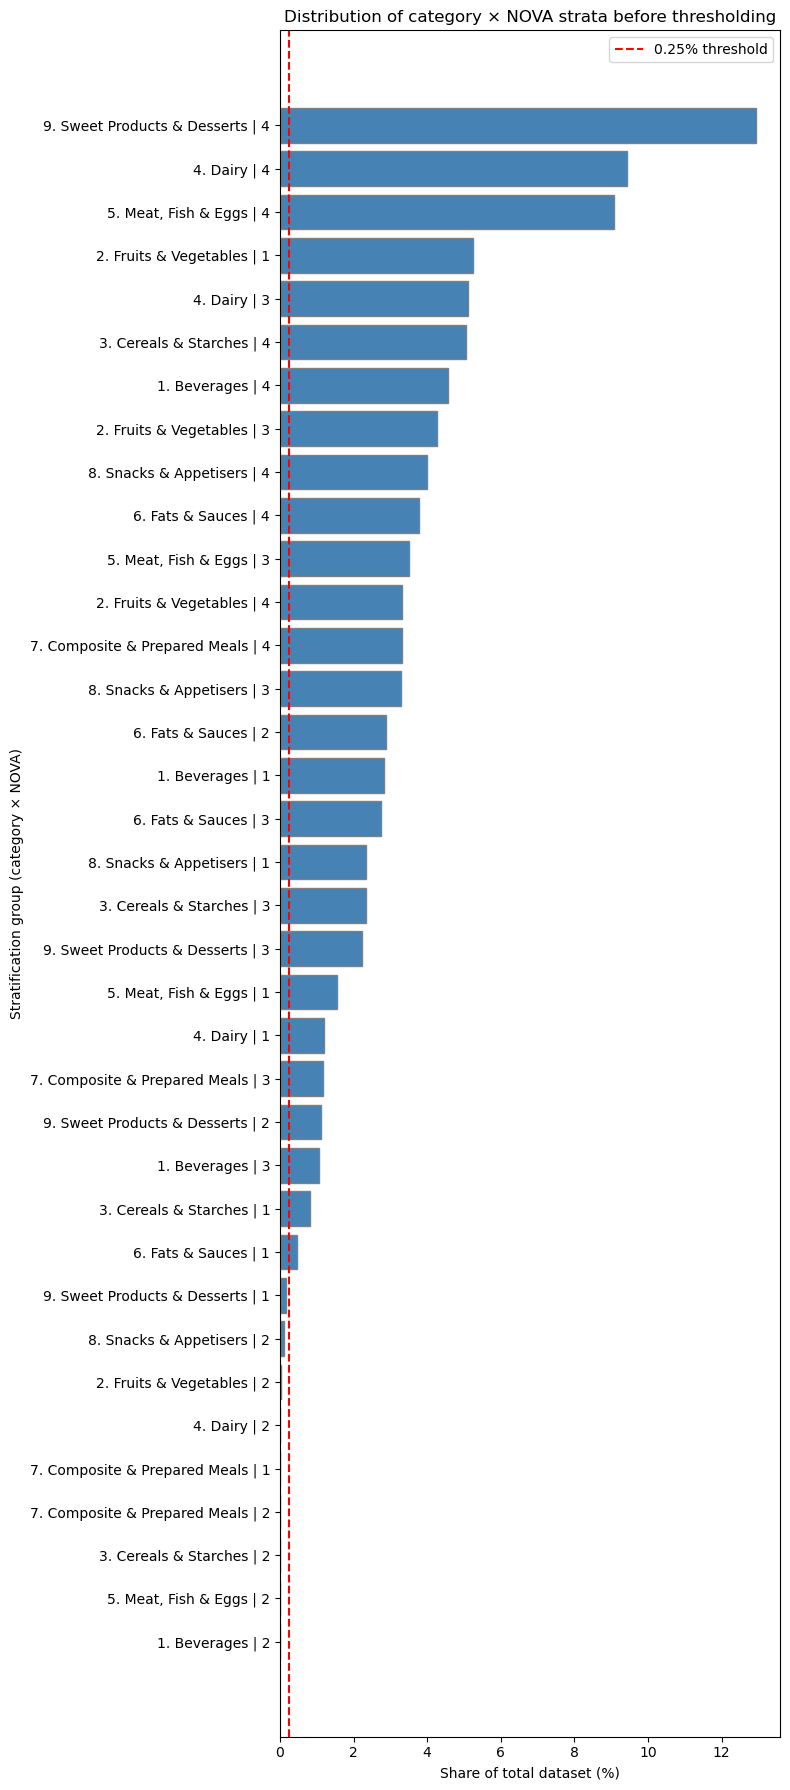

In [25]:
# Sort descending by count
counts_sorted = counts.sort_values("percent", ascending=True)

plt.figure(figsize=(8, 18))  # taller for 120 categories
plt.barh(counts_sorted["stratify_raw"], counts_sorted["percent"], color="steelblue", edgecolor="grey")

plt.xlabel("Share of total dataset (%)")
plt.ylabel("Stratification group (category × NOVA)")
plt.title("Distribution of category × NOVA strata before thresholding")

# optional horizontal line for threshold
plt.axvline(x=0.25, color="red", linestyle="--", label="0.25% threshold")
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
THRESHOLD = 0.20  # percent of total
rare_stratify = counts.loc[counts["percent"] < THRESHOLD, "stratify_raw"]
df["stratify"] = df["stratify_raw"].where(~df["stratify_raw"].isin(rare_stratify), "0.0 Rare")

stratify = df["stratify"].value_counts().reset_index()
stratify.columns = ["stratify", "count"]

total = stratify["count"].sum()
stratify["percent"] = (stratify["count"] / total * 100).round(2)

print(stratify)
stratify.to_csv("../gen/main_stratify_counts_after_threshold.csv", index=False)

                             stratify  count  percent
0    9. Sweet Products & Desserts | 4  38097    12.94
1                        4. Dairy | 4  27745     9.42
2            5. Meat, Fish & Eggs | 4  26723     9.08
3          2. Fruits & Vegetables | 1  15420     5.24
4                        4. Dairy | 3  15073     5.12
5           3. Cereals & Starches | 4  14893     5.06
6                    1. Beverages | 4  13452     4.57
7          2. Fruits & Vegetables | 3  12552     4.26
8          8. Snacks & Appetisers | 4  11812     4.01
9                6. Fats & Sauces | 4  11092     3.77
10           5. Meat, Fish & Eggs | 3  10356     3.52
11         2. Fruits & Vegetables | 4   9795     3.33
12  7. Composite & Prepared Meals | 4   9737     3.31
13         8. Snacks & Appetisers | 3   9724     3.30
14               6. Fats & Sauces | 2   8474     2.88
15                   1. Beverages | 1   8354     2.84
16               6. Fats & Sauces | 3   8106     2.75
17         8. Snacks & Appet

## 4. Global Split data (70/30)

In [29]:
train_idx, test_idx = train_test_split(
    df.index,
    test_size=0.30,
    random_state=0,
    stratify=df["stratify"]
)

df.loc[train_idx, "split"] = "train"
df.loc[test_idx,  "split"] = "test"

print(df["split"].value_counts(normalize=True).round(3))
df.sample(n=25, random_state=0)

split
train    0.7
test     0.3
Name: proportion, dtype: float64


,barcode,product_name,nutriscore,nova_group,mapped_category,labels_string,n_labels_total,labels_1_intrinsic,n_1_intrinsic,labels_2_extrinsic,...,n_3_packaging,brands,countries,n_additives,n_ingredients,main_mapped_category,label_tier,stratify_raw,stratify,split
219728,4260614720923,mediterranes Gemüse,b,3,6.2 Dressings and sauces,EU_ORGANIC_CERT_DE|EU_ORGANIC_LOGO|EU_ORGANIC_...,6,NO_GLUTEN,1,EU_ORGANIC_CERT_DE|EU_ORGANIC_LOGO|EU_ORGANIC_...,...,0,"Littlelunch, little Lunch",germany,0.0,23.0,6. Fats & Sauces,2,6. Fats & Sauces | 3,6. Fats & Sauces | 3,test
150760,8410954002111,Cóctel de encurtidos sabor suave,d,4,2.2 Vegetables,PASTEURIZED,1,PASTEURIZED,1,NaN,...,0,Rioverde,spain,8.0,23.0,2. Fruits & Vegetables,1,2. Fruits & Vegetables | 4,2. Fruits & Vegetables | 4,test
180384,4337185297854,Stieleis Vanille-Erdbeere,d,4,4.4 Ice cream,FSC,1,NaN,0,NaN,...,1,"K-Classic, Kaufland",germany,3.0,20.0,4. Dairy,1,4. Dairy | 4,4. Dairy | 4,test
293277,0850007832742,Mission Minis Kids Sticks,e,3,5.4 Meat,NO_GLUTEN,1,NO_GLUTEN,1,NaN,...,0,Mission Meats,united-states,1.0,16.0,"5. Meat, Fish & Eggs",1,"5. Meat, Fish & Eggs | 3","5. Meat, Fish & Eggs | 3",train
132492,3250390952688,Tripes au cidre,a,4,5.3 Eggs,DISTRIBUTOR_LABELS|GREEN_DOT|ORIGIN_COUNTRY_FR...,5,NaN,0,ORIGIN_COUNTRY_FR_MEAT|ORIGIN_COUNTRY_FR_MEAT_...,...,3,Jean Rozé,france,5.0,25.0,"5. Meat, Fish & Eggs",2,"5. Meat, Fish & Eggs | 4","5. Meat, Fish & Eggs | 4",train
79210,3599740005309,Colin d'Alaska à la Marinière,a,4,5.2 Fish and seafood,NO_COLORINGS|NO_PALM_OIL|NO_PRESERVATIVES,3,NO_COLORINGS|NO_PALM_OIL|NO_PRESERVATIVES,3,NaN,...,0,Findus,france,0.0,19.0,"5. Meat, Fish & Eggs",1,"5. Meat, Fish & Eggs | 4","5. Meat, Fish & Eggs | 4",test
223602,4017100335914,Bahlsen,e,4,8.1 Appetisers,GREEN_DOT|NO_COLORINGS|NO_PRESERVATIVES,3,NO_COLORINGS|NO_PRESERVATIVES,2,NaN,...,1,Bahlsen,germany|luxembourg,2.0,18.0,8. Snacks & Appetisers,2,8. Snacks & Appetisers | 4,8. Snacks & Appetisers | 4,train
277383,8017490050608,Toscano Black 100,e,3,9.3 Chocolate products,FSC|KOSHER|NO_GLUTEN|NO_PRESERVATIVES,4,NO_GLUTEN|NO_PRESERVATIVES,2,KOSHER,...,1,Amedei,italy,0.0,2.0,9. Sweet Products & Desserts,3,9. Sweet Products & Desserts | 3,9. Sweet Products & Desserts | 3,train
229459,8437001702015,Aceite de oliva virgen extra,b,2,6.1 Fats & oils,PDO,1,NaN,0,PDO,...,0,NaN,spain,NaN,NaN,6. Fats & Sauces,1,6. Fats & Sauces | 2,6. Fats & Sauces | 2,test
168963,3560071232245,Foie Gras de Canard entier du Sud-Ouest Mi-Cuit,e,3,5.3 Eggs,LABEL_ROUGE|ORIGIN_COUNTRY_FR|ORIGIN_COUNTRY_F...,5,NaN,0,LABEL_ROUGE|ORIGIN_COUNTRY_FR|ORIGIN_COUNTRY_F...,...,0,"Carrefour, Reflets de France",france,0.0,3.0,"5. Meat, Fish & Eggs",1,"5. Meat, Fish & Eggs | 3","5. Meat, Fish & Eggs | 3",test


## 5. Checks

In [31]:
def pct_table(s):
    """Return % distribution table for a Series"""
    return (s.value_counts(normalize=True)
              .mul(100)
              .round(2)
              .rename("overall_percent")
              .to_frame())

def compare_split(df, col):
    """Compare overall / train / test distributions side-by-side"""
    overall = (df[col].value_counts(normalize=True) * 100).round(2)
    train   = (df.loc[df.split=="train", col].value_counts(normalize=True) * 100).round(2)
    test    = (df.loc[df.split=="test",  col].value_counts(normalize=True) * 100).round(2)
    
    comp = pd.concat([overall, train, test], axis=1, sort=True)
    comp.columns = ["overall_%", "train_%", "test_%"]
    comp = comp.fillna(0).sort_values("overall_%", ascending=False)
    comp = comp.sort_index()

    return comp

# --- Variables to check ---
cols_to_check = ["main_mapped_category", "nova_group", "nutriscore", "label_tier", "stratify"]

for col in cols_to_check:
    comp = compare_split(df, col)
    print(f"\n=== {col} ===")
    print(comp.to_string())


=== main_mapped_category ===
                               overall_%  train_%  test_%
main_mapped_category                                     
1. Beverages                        8.47     8.47    8.47
2. Fruits & Vegetables             12.86    12.87   12.86
3. Cereals & Starches               8.22     8.22    8.22
4. Dairy                           15.77    15.77   15.77
5. Meat, Fish & Eggs               14.14    14.14   14.14
6. Fats & Sauces                    9.87     9.87    9.87
7. Composite & Prepared Meals       4.47     4.47    4.47
8. Snacks & Appetisers              9.75     9.75    9.76
9. Sweet Products & Desserts       16.44    16.45   16.44

=== nova_group ===
            overall_%  train_%  test_%
nova_group                            
1               14.65    14.65   14.64
2                4.14     4.13    4.14
3               25.73    25.73   25.73
4               55.49    55.49   55.49

=== nutriscore ===
            overall_%  train_%  test_%
nutriscore         

## 6. Create Final Datasets

In [33]:
df.loc[df.split=="train"].to_csv("../gen/data_def_train.csv", index=False)
df.loc[df.split=="test"].to_csv("../gen/data_def_test.csv", index=False)